<font size = '6'> __IEOR 222, Financial Engineering Systems 1: Final Project__ </font>

<font size = '5'> __Name:__ Jun Zhang </font>

<font size = '5'> __SID:__ 26041426 </font>

GITHUB LINK:  https://github.com/Jun-Zh/IEOR-222-Final-Project/blob/master/IEOR_Final_Project.ipynb

Please visit the github to see a more complete report as some parts are cut off in the pdf, thank you!

__Main Prompt__:

In class we have analyzed the optimal execution problem using the price impact model of Bertsimas & Lo (1998). In this model, the purchase price Pt at time t, t = 0,1,2,... follows the dynamics:

Pt = Pt−1 + ϵt + θSt,

where

    • ϵt’s are i.i.d. random variables, with E[ϵt|St,Pt−1] = 0, 
    • θ > 0 is a known constant, 
    • St is the purchase amount at time t. 
Note that in this model, the price impact is permanent and linear and the parameter θ is assumed known. In general, there are various forms of price impact models, including 
1. Linear transient price impact, 
2. Linear permanent price impact, 
3. Quadratic temporary price impact. 

This project is thus to use reinforcement learning to get the optimal order execution strategy under various price impact models. Note that by learning, we assume that the parameters in the models are unknown. One therefore need to optimize the order execution while learning the model parameters. 

__Hint:__ The easiest way is to generate synthetic price movements, assume these three forms of price impact with unknown model parameters, and use the Q-learning algorithm to find the optimal execution strategy for each of these models. Using real data would be fairly involved and not required. However, if you could implement with both real data and synthetic data, it would be superb. Your report should contain necessary analysis, figures and codes that support your work. Please submit a single PDF file on bCourses before the deadline. There is no page limit, as long as you could present your findings in a clear and convincing way. 

<font size = '5'> __Part 1) Setting Up the Problem__ </font>

__Idea:__ The reinforcement learning algorithm I will be implementing for learning the optimal execution problem is called 
__Q-Learning__, which is a model free approach that can learn the optimal strategy for selling/buying stocks at different state

__Project Approach:__ To implement the algorithm, I will first need to create a Markove Decision Process of the problem where we can construct the Q-matrix to perform Q-learning. I will define the States, Actions, and Rewards for the __Optimal Order Execution__ problem, The state transition function P will be deterministic in our problem, that means that we assume any order we submit at a given time will be transacted for certain, this will be elaborated further soon.

__Q-Learning__: The algorithm works as follows:
   
    1) Initialize Q-matrix as the zero matrix with appropriate dimension
    2) Randomly choose initial State S
    3) randomly choose admissive action, check outcome, and update Q(s,a) by (1-lambda)*Q(s,a) + lambda(Reward(nextstate)+ max(actions) Q(nextstate,a).
    4) New state is the next observed state
    5) repeat 2-3 until touches target state
    6) repeat 2-5 N number of times
    7) Return matrix Q

![alt text](https://cdn-images-1.medium.com/max/2400/1*jmcVWHHbzCxDc-irBy9JTw.png)

__Problem Assumptions:__

    1) We are required to purchase N number of shares in T time
    2) Time periods are discrete(0... T-1)
    3) N = 40 shares
    4) T = 5
    5) θ = 1, P_0 = 100
    6) Alpha = 1/(1+ numberofvisit(State,action))
    7) Only Market Orders are available, which allows the determinisitic transition between states



__States__: I will define the a state to consist of three factors __S = (p, n,t)__, where p is the price at the given time, n is the number of shares we still need to buy, and t is the time period we are currently at

__Actions__: The actions are obviously buying a # of stocks at time t. But we cannot allow any number of stocks to be bought at each given time as the number of states will grow expoentially. Thus I have decided to allow the number of stocks that can be ought at time t is a multiple __N/T__. Thus for our assumptions, 40/5 = 8. Thus you can buy 0, 8,16,24,32,40  shares at each given time 

__Rewards__: Because the overarching goal of the problem(buy side of the problem) is to minimize the total expected cost of purchasing N number of shares in T period, thus the reward for each action is simply the -(updated price * #of share purchased), as we would want to obtain the largest value which in this case corresponds to the smallest total expected cost. So the reward is __dynamic__ And we will write a function to set the rewards that
    1) over-buy the number of shares (buying 24 shares when you just need 12 more.)
    2) under-buy the number of shares (oustanding shares at time 
to be -1000000 as to make sures the final best solution dont take those paths

__State Transition__: This function will be simply seeing the current price, time period, and number of shares left, and do some arithemtic to get the next state depending on the action of the current state. The important thing to note is that we will be only considering market order, so our state transition function will be deterministic in a way that we will definitely go from one state to another, but the price will be random so it will determine what exact state we will land in for the next time period

In [10]:
#Starting the implementation
#Importing libraries
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as rm

In [11]:
#Auto show graph and suppressing scientific notations
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [8]:
def R_walk():
    return rm.choices(population = [-1, 1], weights = [1/2, 1/2])

In [7]:
def Next_Action(Pop,values):
    W = []
    for i in values:
        W.append(1/(abs(i) +0.001))
    return rm.choices(population = Pop, weights = W)

<font size = '5'> __Part 2a) Linear Permanent Price Impact Model__ </font>

The __Linear Permanent Price Impact Model__ assumes the relation of the following:
    
    Pt = Pt−1 + ϵt + θSt

Which means that the next price is a linear combination of the previous price and theta*(# of shares you are purchasing) + some random noise that is independent from S and P.

We will be sampling ϵ from a random walk with taking value in {-1, 1} with equal probabilities , and with the other parameters stated above (θ = 0.5, P0 = 10).

In [9]:
#Setting up parameters
T = 5 # Time periods
N = 40 # Amount of shares
Theta= 1 #Constant
P_0 = 100 #Initial Stock Price

In [12]:
#Constructing State Transition Function for Linear Permanent Price Impact Model,
def Next_state(state, action):
    Price = Next_Price(state[0], Theta, action)
    return (Price, state[1]+1, state[2] - action)
  
#Constructing the Reward Funciton
def Next_Price(Price, Theta, Share):
    noise = R_walk()
    return Price + noise[0] + Theta*(Share)

In [13]:
#Constructing the Action
A = []
for i in range(T+1):
    A.append(N/(T)*i)

In [14]:
#All possible actions
A

[0.0, 8.0, 16.0, 24.0, 32.0, 40.0]

In [13]:
#Constructing the States, to do this I am just running througuh all possible tracjectories through starting at initial state, and choosing random action each time, 
#Then if we take this loop to a very large number, we should find all possible states, and if I didn't find all possible states then my Q-Learning algorithm would fail later on.
States = []
States.append((P_0*1.0, 0 ,N*1.0))

for i in range(100000):
    S = (P_0, 0 ,N)

    while S[1] != T-1:
        Action = rm.choice(A)
        if S[2] >= Action:
            price = S[0] + R_walk()[0] + Theta*Action

            S = (price, S[1] + 1, S[2] - Action)
            States.append(S)
States = set(States)
States = list(States)
S = States
S.sort(key = lambda tup: (tup[1],tup[2]))

In [ ]:
#We can see the total number of states we have now
len(S)

In [16]:
price_change[0]

[100, 117.0, 124.0, 133.0, 132.0]

In [0]:
#Setting up the Q-Matrix
row_index = {}
col_index = {}
for i in range(len(S)):
    row_index[i] = S[i]
for i in range(len(A)):
    col_index[i] = A[i]
    
Q = np.zeros((len(S),len(A)))
Q = pd.DataFrame(Q)

Q.rename(index = row_index, inplace = True)
Q.rename(columns= col_index, inplace=True)

In [0]:
#Creating a copy of the states/acitons so that I can apply dynamic learning rate

C = Q.copy()


In [0]:
#setting up the inital reward for terminal states
End_state = []
Other_state = []
for i in S:
    if i[1] == T - 1:
        End_state.append(i)
    else:
        Other_state.append(i)

In [0]:
#notice I didn't add the noise term in calculating the final reward, as e has expectation 0, so in the long term the 
#noise term should cancel out
#I am initializing the Q-matrix so that all the infeasible actions(trying to buy more shares than you actually need) are -100000.., and that at the final state, the reward will just be the cost of buying the
#remaining shares
for state in End_state:
    for action in A:
        if state[2] != action:
            Q.at[state,action] = -10000000
        else:
            price = state[0]
            price = price + Theta*state[2] 
            reward = -1*(price*state[2])
            Q.at[state,action] = reward

            
for state in Other_state:
    for action in A:
        if state[2] < action:
            Q.at[state,action] = -10000000


In [0]:
#Checking whether the final reward is set correctly
Q.tail()


,0.0,8.0,16.0,24.0,32.0,40.0
"(104.0, 4, 40.0)",-10000000.000,-10000000.000,-10000000.000,-10000000.000,-10000000.000,-5760.000
"(100.0, 4, 40.0)",-10000000.000,-10000000.000,-10000000.000,-10000000.000,-10000000.000,-5600.000
"(96.0, 4, 40.0)",-10000000.000,-10000000.000,-10000000.000,-10000000.000,-10000000.000,-5440.000
"(98.0, 4, 40.0)",-10000000.000,-10000000.000,-10000000.000,-10000000.000,-10000000.000,-5520.000
"(102.0, 4, 40.0)",-10000000.000,-10000000.000,-10000000.000,-10000000.000,-10000000.000,-5680.000


In [0]:
#Constructing a list so that I will start in a state thats not terminal state
start = [i for i in S if i[1] != T-1] 
len(start)

55

In [0]:
#Pre-construct a dictionary of feasible actions base on how many shares you have left to buy
P_act = {}

for i in A:
    P_act[i] = [j for j in A if i >= j] 

In [0]:
#Can see the #"number of shares left to buy" to the list of feasible shares
P_act

{0.0: [0.0],
 8.0: [0.0, 8.0],
 16.0: [0.0, 8.0, 16.0],
 24.0: [0.0, 8.0, 16.0, 24.0],
 32.0: [0.0, 8.0, 16.0, 24.0, 32.0],
 40.0: [0.0, 8.0, 16.0, 24.0, 32.0, 40.0]}

In [0]:
#Here I will define a function for the Q-learning algorithm so I can use it in the next section as well, the Linear Transient model will be
#different as the price is updated differently
def Qlearning(Q, start_q, P_act_q, Next_state, num,C):
    iters = num
    for i in range(iters):
        Current_state = rm.choice(start_q)
        price = Current_state[0]
        while Current_state[1] != 4:
            M = P_act_q[Current_state[2]]
            Action = Next_Action(M,np.array(Q.loc[[Current_state]])[0][0:len(M)])[0]
            if Current_state[2] < Action:
                Q_q.at[Current_state,Action] = -10000000
            else:
                N_state = Next_state(Current_state, Action)
                price = N_state[0]
                reward = -price*Action
                alpha = 1/(1+C.at[Current_state,Action]/20)
                C.at[Current_state,Action] += 1
                Q.at[Current_state,Action] = (1-alpha)*Q.at[Current_state,Action] + \
                alpha*(reward + max(np.array(Q.loc[[N_state]])[0]))
            
                Current_state = N_state

In [0]:
#Running the algorithm 1000000 times
Qlearning(Q,start,P_act,Next_state,100000,C)

In [0]:
#resulting Matrix
Q

,0.0,8.0,16.0,24.0,32.0,40.0
"(100.0, 0, 40.0)",-5025.715,-4957.776,-5028.218,-5154.094,-5345.597,-5604.261
"(141.0, 1, 0.0)",0.000,-10000000.000,-10000000.000,-10000000.000,-10000000.000,-10000000.000
"(139.0, 1, 0.0)",0.000,-10000000.000,-10000000.000,-10000000.000,-10000000.000,-10000000.000
"(133.0, 1, 8.0)",-1126.546,-1127.397,-10000000.000,-10000000.000,-10000000.000,-10000000.000
"(131.0, 1, 8.0)",-1110.457,-1111.742,-10000000.000,-10000000.000,-10000000.000,-10000000.000
"(125.0, 1, 16.0)",-2189.831,-2193.616,-2257.175,-10000000.000,-10000000.000,-10000000.000
"(123.0, 1, 16.0)",-2158.046,-2159.539,-2223.256,-10000000.000,-10000000.000,-10000000.000
"(115.0, 1, 24.0)",-3145.426,-3145.200,-3207.542,-3337.567,-10000000.000,-10000000.000
"(117.0, 1, 24.0)",-3194.170,-3190.305,-3257.460,-3383.872,-10000000.000,-10000000.000
"(109.0, 1, 32.0)",-4190.191,-4121.236,-4194.122,-4323.908,-4515.405,-10000000.000


In [0]:
#checking the number of visit
C

,0.0,8.0,16.0,24.0,32.0,40.0
"(100.0, 0, 40.0)",602.000,647.000,604.000,572.000,585.000,562.000
"(141.0, 1, 0.0)",3912.000,0.000,0.000,0.000,0.000,0.000
"(139.0, 1, 0.0)",3910.000,0.000,0.000,0.000,0.000,0.000
"(133.0, 1, 8.0)",1940.000,1901.000,0.000,0.000,0.000,0.000
"(131.0, 1, 8.0)",1939.000,2015.000,0.000,0.000,0.000,0.000
"(125.0, 1, 16.0)",1250.000,1337.000,1307.000,0.000,0.000,0.000
"(123.0, 1, 16.0)",1394.000,1263.000,1291.000,0.000,0.000,0.000
"(115.0, 1, 24.0)",1058.000,1024.000,1031.000,988.000,0.000,0.000
"(117.0, 1, 24.0)",1065.000,978.000,1009.000,937.000,0.000,0.000
"(109.0, 1, 32.0)",865.000,810.000,777.000,753.000,743.000,0.000


In [0]:
#Base on the theory we developed in class and observing the resulting matrix, below is the optimal route states
Optimal = []
for i in S:
    if i[2] == N - i[1]*A[1]:
        Optimal.append(i) 
Optimal

[(100.0, 0, 40.0),
 (109.0, 1, 32.0),
 (107.0, 1, 32.0),
 (114.0, 2, 24.0),
 (118.0, 2, 24.0),
 (116.0, 2, 24.0),
 (121.0, 3, 16.0),
 (125.0, 3, 16.0),
 (127.0, 3, 16.0),
 (123.0, 3, 16.0),
 (132.0, 4, 8.0),
 (128.0, 4, 8.0),
 (130.0, 4, 8.0),
 (134.0, 4, 8.0),
 (136.0, 4, 8.0)]

In [0]:
#Here we can check the optimal strategy if we just start at initial time and follow the optimal route, and notice how when you are at the same time period with same number
#of shares left to buy, the price doesn't affect your action within the optimal route, and the optimal strategy is to sell 40/5 (N/T) = 8 shares each time
Q.loc[Optimal].idxmax(axis =1)

(100.0, 0, 40.0)   8.000
(109.0, 1, 32.0)   8.000
(107.0, 1, 32.0)   8.000
(114.0, 2, 24.0)   8.000
(118.0, 2, 24.0)   8.000
(116.0, 2, 24.0)   8.000
(121.0, 3, 16.0)   8.000
(125.0, 3, 16.0)   8.000
(127.0, 3, 16.0)   8.000
(123.0, 3, 16.0)   8.000
(132.0, 4, 8.0)    8.000
(128.0, 4, 8.0)    8.000
(130.0, 4, 8.0)    8.000
(134.0, 4, 8.0)    8.000
(136.0, 4, 8.0)    8.000
dtype: float64

Above we can see the optimal strategy starting at time = 0, the optimal strategy is always to sell 40/5 = 8 shares at the given time with the right amount of shares. 


In [0]:
#See below for the actually row values along the optimal route
Q.loc[Optimal]

,0.0,8.0,16.0,24.0,32.0,40.0
"(100.0, 0, 40.0)",-5025.715,-4957.776,-5028.218,-5154.094,-5345.597,-5604.261
"(109.0, 1, 32.0)",-4190.191,-4121.236,-4194.122,-4323.908,-4515.405,-10000000.000
"(107.0, 1, 32.0)",-4132.672,-4065.922,-4131.179,-4249.436,-4445.413,-10000000.000
"(114.0, 2, 24.0)",-3184.706,-3118.899,-3183.952,-3311.980,-10000000.000,-10000000.000
"(118.0, 2, 24.0)",-3279.303,-3216.003,-3280.423,-3406.145,-10000000.000,-10000000.000
"(116.0, 2, 24.0)",-3231.404,-3168.143,-3233.420,-3360.583,-10000000.000,-10000000.000
"(121.0, 3, 16.0)",-2190.893,-2125.331,-2190.427,-10000000.000,-10000000.000,-10000000.000
"(125.0, 3, 16.0)",-2257.099,-2191.945,-2255.422,-10000000.000,-10000000.000,-10000000.000
"(127.0, 3, 16.0)",-2289.071,-2223.711,-2287.613,-10000000.000,-10000000.000,-10000000.000
"(123.0, 3, 16.0)",-2224.610,-2159.484,-2224.951,-10000000.000,-10000000.000,-10000000.000


In [36]:
#Here I want to plot how stock price changes vs our action
price_change = [0 for i in range(10)]
for i in range(10):
    d = (P_0, 0 ,N)
    price_change[i] = []
    price_change[i].append(P_0)
    while d[1] != T-1:
        Action = 8
        if d[2] >= Action:
            price = d[0] + R_walk()[0] + Theta*Action
            price_change[i].append(price)
            d = (price, d[1] + 1, d[2] - Action)


Text(0.5, 0, 'Time Period')

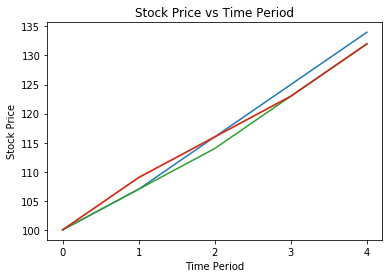

In [37]:
#Below we can see some price changes through the period of time just through our action 
#of buying 8 shares per time, since the impact is permanent we see that
#there is no decrease in price, and it only differes in the noise
plt.plot(price_change[0])
plt.plot(price_change[1])
plt.plot(price_change[2])
plt.plot(price_change[3])

plt.xticks(np.arange(0, 4+1, 1.0))
plt.title("Stock Price vs Time Period")
plt.ylabel("Stock Price")
plt.xlabel("Time Period")

<font size = '5'> __Part 2b) Quadratic Price Impact Model__ </font>

The __Quadratic Temporary Price Impact Model__ assumes the relation of the following:
    
    Pt = Pt−1 + ϵt + a(St)^2 + b(St)

Which means that the next price is a linear combination of the previous price and theta*(# of shares you are purchasing) + some random noise that is independent from S and P.

We will be sampling ϵ from a random walk with taking value in {-1, 1} with equal probabilities , and with the other parameters stated above (θ = 0.5, P0 = 10).

In [3]:
# we will be using the same parameters as above, with new paramaters a,b. I will just redefine them again here
T = 5 # Time periods
N = 40 # Amount of shares
P_0 = 100 #Initial Stock Price
a = 0.5
b = 1

In [15]:
#Same possible Action
A

[0.0, 8.0, 16.0, 24.0, 32.0, 40.0]

In [16]:
#Defining the new functions for state and price because the model is different
def Next_state_q(state, action):
    Price = Next_Price_q(state[0], action)
    return (Price, state[1]+1, state[2] - action)

def Next_Price_q(Price, Share):
    noise = R_walk()
    return Price + noise[0] + a*(Share*Share) + b*Share

In [17]:
#Constructing the States again
States_q = []
States_q.append((P_0*1.0, 0 ,N*1.0))
for i in range(200000):
    C = (P_0, 0 ,N)
    while C[1] != T-1:
        Action = rm.choice(A)
        if C[2] >= Action:
            price = round(Next_Price_q(C[0], Action)) * 1.0
            C = (price, C[1] + 1, C[2] - Action)
            States_q.append(C)
States_q = set(States_q)
States_q = list(States_q)
S_q = States_q
S_q.sort(key = lambda tup: (tup[1],tup[2]))
S_q[0:20]

[(100.0, 0, 40.0),
 (941.0, 1, 0.0),
 (939.0, 1, 0.0),
 (645.0, 1, 8.0),
 (643.0, 1, 8.0),
 (413.0, 1, 16.0),
 (411.0, 1, 16.0),
 (243.0, 1, 24.0),
 (245.0, 1, 24.0),
 (139.0, 1, 32.0),
 (141.0, 1, 32.0),
 (101.0, 1, 40.0),
 (99.0, 1, 40.0),
 (682.0, 2, 0.0),
 (684.0, 2, 0.0),
 (558.0, 2, 0.0),
 (686.0, 2, 0.0),
 (938.0, 2, 0.0),
 (940.0, 2, 0.0),
 (554.0, 2, 0.0)]

In [18]:
len(S_q)

203

In [0]:
#Setting up for initializing the Q_matrix
End_state_q = []
Other_state_q = []
for i in S_q:
    if i[1] == T - 1:
        End_state_q.append(i)
    else:
        Other_state_q.append(i)
len(Other_state_q)

113

In [0]:
#Setting up the Q-Matrix
row_index = {}
col_index = {}
for i in range(len(S_q)):
    row_index[i] = S_q[i]
for i in range(len(A)):
    col_index[i] = A[i]
    
Q_q = np.zeros((len(S_q),len(A)))
Q_q = pd.DataFrame(Q_q)
Q_q.rename(index = row_index, inplace = True)
Q_q.rename(columns= col_index, inplace=True)

In [0]:
#Again creating a copy of the matrix for dynamic learning rate = 1/(1+#ofvisit)
C_q = Q_q.copy()

In [0]:
#notice I didn't add the noise term in calculating the final reward, as e has expectation 0, so in the long term the 
#noise term should cancel out, setting up initial award and infeasible actions
price = 0
for state in End_state_q:
    for action in A:
        if state[2] != action:
            Q_q.at[state,action] = -10000000
        else:
            price = round(Next_Price_q(state[0], action)) *1.0
            reward = -1*(price*state[2])
            Q_q.at[state,action] = reward

for state in Other_state_q:
    for action in A:
        if state[2] < action:
            Q_q.at[state,action] = -10000000


In [0]:
Q_q.head()

,0.0,8.0,16.0,24.0,32.0,40.0
"(100.0, 0, 40.0)",0.000,0.000,0.000,0.000,0.000,0.000
"(941.0, 1, 0.0)",0.000,-10000000.000,-10000000.000,-10000000.000,-10000000.000,-10000000.000
"(939.0, 1, 0.0)",0.000,-10000000.000,-10000000.000,-10000000.000,-10000000.000,-10000000.000
"(645.0, 1, 8.0)",0.000,0.000,-10000000.000,-10000000.000,-10000000.000,-10000000.000
"(643.0, 1, 8.0)",0.000,0.000,-10000000.000,-10000000.000,-10000000.000,-10000000.000


In [0]:
#Same function for starting place
start_qu = [i for i in S_q if i[1] != 4] 
len(start_qu)

113

In [0]:
#Feasible Actions
P_act_qu = {}
for i in A:
    P_act_qu[i] = [j for j in A if i >= j]

In [0]:
P_act_qu

{0.0: [0.0],
 8.0: [0.0, 8.0],
 16.0: [0.0, 8.0, 16.0],
 24.0: [0.0, 8.0, 16.0, 24.0],
 32.0: [0.0, 8.0, 16.0, 24.0, 32.0],
 40.0: [0.0, 8.0, 16.0, 24.0, 32.0, 40.0]}

In [0]:
#Running the algorithm 100000 times
Qlearning(Q_q, start_qu, P_act_qu, Next_state_q, 100000,C_q)

In [0]:
#After obvserving the Q matrix, this is the optimal route, considering all possible prices at a given time and number of shares reamining.
Optimal_q = []
for i in S_q:
    
    if i[2] == 40 - i[1]*8:
        Optimal_q.append(i)
Optimal_q

[(100.0, 0, 40.0),
 (139.0, 1, 32.0),
 (141.0, 1, 32.0),
 (182.0, 2, 24.0),
 (242.0, 2, 24.0),
 (246.0, 2, 24.0),
 (180.0, 2, 24.0),
 (178.0, 2, 24.0),
 (244.0, 2, 24.0),
 (287.0, 3, 16.0),
 (283.0, 3, 16.0),
 (223.0, 3, 16.0),
 (219.0, 3, 16.0),
 (415.0, 3, 16.0),
 (411.0, 3, 16.0),
 (285.0, 3, 16.0),
 (221.0, 3, 16.0),
 (281.0, 3, 16.0),
 (413.0, 3, 16.0),
 (217.0, 3, 16.0),
 (409.0, 3, 16.0),
 (452.0, 4, 8.0),
 (322.0, 4, 8.0),
 (326.0, 4, 8.0),
 (644.0, 4, 8.0),
 (448.0, 4, 8.0),
 (392.0, 4, 8.0),
 (450.0, 4, 8.0),
 (454.0, 4, 8.0),
 (640.0, 4, 8.0),
 (328.0, 4, 8.0),
 (260.0, 4, 8.0),
 (642.0, 4, 8.0),
 (646.0, 4, 8.0),
 (256.0, 4, 8.0),
 (456.0, 4, 8.0),
 (264.0, 4, 8.0),
 (388.0, 4, 8.0),
 (258.0, 4, 8.0),
 (262.0, 4, 8.0),
 (648.0, 4, 8.0),
 (324.0, 4, 8.0),
 (320.0, 4, 8.0),
 (384.0, 4, 8.0),
 (386.0, 4, 8.0),
 (390.0, 4, 8.0)]

In [0]:
#Below shows the optimal choice at each state following the optimal route
Q_q.loc[Optimal_q].idxmax(axis=1)



(100.0, 0, 40.0)   8.000
(139.0, 1, 32.0)   8.000
(141.0, 1, 32.0)   8.000
(182.0, 2, 24.0)   8.000
(242.0, 2, 24.0)   8.000
(246.0, 2, 24.0)   8.000
(180.0, 2, 24.0)   8.000
(178.0, 2, 24.0)   8.000
(244.0, 2, 24.0)   8.000
(287.0, 3, 16.0)   8.000
(283.0, 3, 16.0)   8.000
(223.0, 3, 16.0)   8.000
(219.0, 3, 16.0)   8.000
(415.0, 3, 16.0)   8.000
(411.0, 3, 16.0)   8.000
(285.0, 3, 16.0)   8.000
(221.0, 3, 16.0)   8.000
(281.0, 3, 16.0)   8.000
(413.0, 3, 16.0)   8.000
(217.0, 3, 16.0)   8.000
(409.0, 3, 16.0)   8.000
(452.0, 4, 8.0)    8.000
(322.0, 4, 8.0)    8.000
(326.0, 4, 8.0)    8.000
(644.0, 4, 8.0)    8.000
(448.0, 4, 8.0)    8.000
(392.0, 4, 8.0)    8.000
(450.0, 4, 8.0)    8.000
(454.0, 4, 8.0)    8.000
(640.0, 4, 8.0)    8.000
(328.0, 4, 8.0)    8.000
(260.0, 4, 8.0)    8.000
(642.0, 4, 8.0)    8.000
(646.0, 4, 8.0)    8.000
(256.0, 4, 8.0)    8.000
(456.0, 4, 8.0)    8.000
(264.0, 4, 8.0)    8.000
(388.0, 4, 8.0)    8.000
(258.0, 4, 8.0)    8.000
(262.0, 4, 8.0)    8.000


Again, we can see the optimal strategy is to sell __N/T = 8 shares__ per time, and again we observe that the price doesnt matter. Which makes sense as we have a linear model and the price increases permanently, so that the price at given point doesnt really matter but is the number of shares and time period that determines the optimal action

In [0]:
#Below shows the row values for the optimal route
Q_q.loc[Optimal_q]

,0.0,8.0,16.0,24.0,32.0,40.0
"(100.0, 0, 40.0)",-10132.974,-8802.430,-11690.257,-17455.505,-26059.090,-37590.951
"(139.0, 1, 32.0)",-8994.494,-7642.470,-10009.102,-14736.745,-21852.500,-10000000.000
"(141.0, 1, 32.0)",-9068.288,-7720.286,-10075.053,-14807.583,-21919.830,-10000000.000
"(182.0, 2, 24.0)",-7650.544,-6294.518,-8148.645,-11858.596,-10000000.000,-10000000.000
"(242.0, 2, 24.0)",-9081.928,-7732.608,-9583.847,-13299.169,-10000000.000,-10000000.000
"(246.0, 2, 24.0)",-9158.228,-7830.655,-9676.975,-13397.241,-10000000.000,-10000000.000
"(180.0, 2, 24.0)",-7589.242,-6241.863,-8098.163,-11799.902,-10000000.000,-10000000.000
"(178.0, 2, 24.0)",-7544.013,-6186.424,-8042.406,-11764.304,-10000000.000,-10000000.000
"(244.0, 2, 24.0)",-9132.575,-7783.348,-9638.137,-13343.867,-10000000.000,-10000000.000
"(287.0, 3, 16.0)",-6880.490,-5552.112,-6896.668,-10000000.000,-10000000.000,-10000000.000


In [41]:
#Here I want to plot how stock price changes vs our action
price_change = [0 for i in range(10)]
for i in range(10):
    d = (P_0, 0 ,N)
    price_change[i] = []
    price_change[i].append(P_0)
    while d[1] != T-1:
        Action = 8
        if d[2] >= Action:
            price = d[0] + R_walk()[0] + 0.5*Action*Action + Action
            price_change[i].append(price)
            d = (price, d[1] + 1, d[2] - Action)

Text(0.5, 0, 'Time Period')

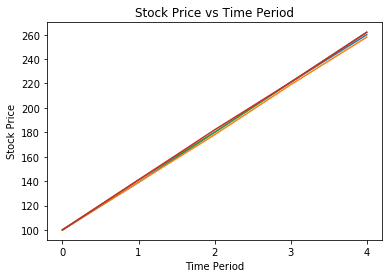

In [42]:
#Below we can see some price changes through the period of time just through our action 
#of buying 8 shares per time, since the impact is permanent we see that
#there is no decrease in price, and it only differes in the noise
plt.plot(price_change[0])
plt.plot(price_change[1])
plt.plot(price_change[2])
plt.plot(price_change[3])

plt.xticks(np.arange(0, 4+1, 1.0))
plt.title("Stock Price vs Time Period")
plt.ylabel("Stock Price")
plt.xlabel("Time Period")

We can see that there is barely a difference in the price change as the noise only takes a small part now

<font size = '5'> __Part 2c) Linear Transient Price Impact Model__ </font>

The __Quadratic Temporary Price Impact Model__ assumes the relation of the following:
    
    Pt = P0 + SUM(S<=t) (ϵt) + SUM(s<=t) (e^-alpha*(t-s) * theta *S_s)

Which means that the next price is a linear combination of the previous price and theta*(# of shares you are purchasing) + some random noise that is independent from S and P.

We will be sampling ϵ from a random walk with taking value in {-1, 1} with equal probabilities , and with the other parameters (θ = 10, P0 = 100).

The state, action and reward will all be changed accordingly but following the same idea

I changed the starting parameter of this model for ease of explaination, as the absolute quantity of shares and 
the price doesn't matter, but the number of time periods and the action space is really the crucial thing that 
we should analyze our result upon

In [43]:
#I want to have a little more action space to analyze how this model will behave, thus I will adjust the parameter a little here, 
#Now the number of shares is 3
# and action can be any 0 - 3 integers
T_e = 5 # Time periods
N_e = 3 # Amount of shares
beta_e = 0.25
Theta_e = 10
P_0_e = 100 #Initial Stock Price
A = [0.0,1.0,2.0, 3.0]

In [44]:
A_e = A
#Constructing the States
States_e = []
States_e.append((P_0_e*1.0, 0 ,N_e*1.0))
for i in range(200000):
    C_e = (P_0_e, 0 ,N_e)
    pastaction = []
    price_0 = P_0_e
    Sum_e = 0
    while C_e[1] != T_e-1:
        Action = rm.choice(A_e)
        if C_e[2] >= Action:
            pastaction.append(Action)
            Sum_e += R_walk()[0]
            decay = 0
            for i in range(len(pastaction)):
                decay += round(np.exp(-1*beta_e*(C_e[1]-i))*Theta_e*pastaction[i])
            price = price_0 + Sum_e + decay
            C_e = (price, C_e[1] + 1, C_e[2] - Action)
            States_e.append(C_e)
States_e = set(States_e)
States_e = list(States_e)
S_e = States_e
S_e.sort(key = lambda tup: (tup[1],tup[2]))

In [45]:
#We can see the totaly number of states in this case
len(S_e)

118

In [781]:
S_e[0:5]

[(100.0, 0, 3.0),
 (131.0, 1, 0.0),
 (129.0, 1, 0.0),
 (119.0, 1, 1.0),
 (121.0, 1, 1.0)]

In [0]:
#Setting up the Q-Matrix
row_index = {}
col_index = {}
for i in range(len(S_e)):
    row_index[i] = S_e[i]
for i in range(len(A_e)):
    col_index[i] = A_e[i]
    
Q_e = np.zeros((len(S_e),len(A_e)))
Q_e = pd.DataFrame(Q_e)
Q_e.rename(index = row_index, inplace = True)
Q_e.rename(columns= col_index, inplace=True)

In [784]:
Q_e[0:5]

,0.0,1.0,2.0,3.0
"(100.0, 0, 3.0)",0.000,0.000,0.000,0.000
"(131.0, 1, 0.0)",0.000,0.000,0.000,0.000
"(129.0, 1, 0.0)",0.000,0.000,0.000,0.000
"(119.0, 1, 1.0)",0.000,0.000,0.000,0.000
"(121.0, 1, 1.0)",0.000,0.000,0.000,0.000


In [0]:
C_e = Q_e.copy()

In [0]:
#setting up the inital reward for terminal states
End_state_e = []
Other_state_e = []
for i in S_e:
    if i[1] == T_e - 1:
        End_state_e.append(i)
    else:
        Other_state_e.append(i)

In [788]:
len(Other_state_e)

61

In [0]:
#notice I didn't add the noise term in calculating the final reward, as e has expectation 0, so in the long term the 
#noise term should cancel out
for state in End_state_e:
    for action in A_e:
        if state[2] != action:
            Q_e.at[state,action] = -10000000

for state in Other_state_e:
    for action in A_e:
        if state[2] < action:
            Q_e.at[state,action] = -10000000


In [790]:
start_e = [i for i in S_e if i[1] != 4] 
len(start_e)


61

In [0]:
P_act_e = {}
for i in A_e:
    P_act_e[i] = [j for j in A_e if i >= j]

    

In [792]:
P_act_e

{0.0: [0.0], 1.0: [0.0, 1.0], 2.0: [0.0, 1.0, 2.0], 3.0: [0.0, 1.0, 2.0, 3.0]}

In [0]:
Q_e.tail()

,0.0,1.0,2.0,3.0,4.0,5.0,6.0
"(100.0, 4, 6.0)",-10000000.000,-10000000.000,-10000000.000,-10000000.000,-10000000.000,-10000000.000,0.000
"(96.0, 4, 6.0)",-10000000.000,-10000000.000,-10000000.000,-10000000.000,-10000000.000,-10000000.000,0.000
"(102.0, 4, 6.0)",-10000000.000,-10000000.000,-10000000.000,-10000000.000,-10000000.000,-10000000.000,0.000
"(98.0, 4, 6.0)",-10000000.000,-10000000.000,-10000000.000,-10000000.000,-10000000.000,-10000000.000,0.000
"(104.0, 4, 6.0)",-10000000.000,-10000000.000,-10000000.000,-10000000.000,-10000000.000,-10000000.000,0.000


In [0]:
def Q_learning_e(num):
  iters = num
  for i in range(iters):
    Current_state = S_e[0]
    price = Current_state[0]
    Sum_e = 0
    pastaction = []
    while Current_state[1] != T_e-1:
        M = P_act_e[Current_state[2]]
        Action = Next_Action(M,np.array(Q_e.loc[[Current_state]])[0][0:len(M)])[0]
        
        pastaction.append(Action)
        Sum_e += R_walk()[0]
        decay = 0
        for i in range(len(pastaction)):
            decay += round(np.exp(-1*beta_e*(Current_state[1]-i))*Theta_e*pastaction[i])
            
        price = price_0 + Sum_e + decay
        N_state = (price, Current_state[1] + 1, Current_state[2] - Action)
        
        reward = -price*Action
        
        alpha = 1/(1+  C_e.at[Current_state,Action]/20)
        C_e.at[Current_state,Action] += 1
        
        Q_e.at[Current_state,Action] = (1-alpha)*Q_e.at[Current_state,Action] + \
        alpha*(reward + max(np.array(Q_e.loc[[N_state]])[0]))
            
        Current_state = N_state
        
    pastaction.append(Current_state[2])
    Sum_e += R_walk()[0]
    decay = 0
    for i in range(len(pastaction)):
        decay += round(np.exp(-1*beta_e*(Current_state[1]-i))*Theta_e*pastaction[i])
    price = price_0 + Sum_e + decay
    reward = -price* Current_state[2]
    Q_e.at[Current_state,Current_state[2]] = reward
    

In [0]:
Q_learning_e(20000)

In [806]:
Q_e

,0.0,1.0,2.0,3.0
"(100.0, 0, 3.0)",-349.096,-345.839,-356.708,-389.969
"(131.0, 1, 0.0)",0.000,-10000000.000,-10000000.000,-10000000.000
"(129.0, 1, 0.0)",0.000,-10000000.000,-10000000.000,-10000000.000
"(119.0, 1, 1.0)",-115.934,-125.084,-10000000.000,-10000000.000
"(121.0, 1, 1.0)",-117.719,-127.032,-10000000.000,-10000000.000
"(109.0, 1, 2.0)",-234.132,-234.652,-254.180,-10000000.000
"(111.0, 1, 2.0)",-237.437,-238.144,-258.124,-10000000.000
"(101.0, 1, 3.0)",-354.800,-351.615,-362.373,-392.977
"(99.0, 1, 3.0)",-349.650,-346.086,-357.338,-386.807
"(125.0, 2, 0.0)",0.000,-10000000.000,-10000000.000,-10000000.000


In [807]:
Result = [i for i in S_e if i[1]== 0]
Q_e.loc[Result].idxmax(axis=1)

(100.0, 0, 3.0)   1.000
dtype: float64

In [808]:
Result = [i for i in S_e if ((i[1]== 1) & (i[2] == 2.0)) ]
Q_e.loc[Result].idxmax(axis=1)

(109.0, 1, 2.0)   0.000
(111.0, 1, 2.0)   0.000
dtype: float64

In [809]:
Result = [i for i in S_e if ((i[1]== 2) & (i[2] == 2.0))]
Q_e.loc[Result].idxmax(axis=1)

(106.0, 2, 2.0)   1.000
(108.0, 2, 2.0)   1.000
(110.0, 2, 2.0)   1.000
(112.0, 2, 2.0)   1.000
dtype: float64

In [810]:
Result = [i for i in S_e if ((i[1]== 3) & (i[2] == 1.0))]
Q_e.loc[Result].idxmax(axis=1)

(117.0, 3, 1.0)   0.000
(119.0, 3, 1.0)   0.000
(113.0, 3, 1.0)   0.000
(115.0, 3, 1.0)   0.000
(121.0, 3, 1.0)   0.000
(123.0, 3, 1.0)   0.000
(109.0, 3, 1.0)   0.000
(111.0, 3, 1.0)   0.000
dtype: float64

In [811]:
Result = [i for i in S_e if ((i[1]== 4) & (i[2] == 1.0))]
Q_e.loc[Result].idxmax(axis=1)

(110.0, 4, 1.0)   1.000
(124.0, 4, 1.0)   1.000
(112.0, 4, 1.0)   1.000
(114.0, 4, 1.0)   1.000
(118.0, 4, 1.0)   1.000
(120.0, 4, 1.0)   1.000
(111.0, 4, 1.0)   1.000
(122.0, 4, 1.0)   1.000
(119.0, 4, 1.0)   1.000
(107.0, 4, 1.0)   1.000
(109.0, 4, 1.0)   1.000
(115.0, 4, 1.0)   1.000
(108.0, 4, 1.0)   1.000
(117.0, 4, 1.0)   1.000
(105.0, 4, 1.0)   1.000
(116.0, 4, 1.0)   1.000
(113.0, 4, 1.0)   1.000
dtype: float64

We can see from the above example that the optimal strategy for 3 shares in 5 periods is __1, 0, 1, 0, 1.__





__Now I will try to train the transient model again with another set of parameters for another example. __

In [0]:
#Saving the Q_matrix
Q_e_3share = Q_e.copy()


In [0]:
#I want to have a little more action space to analyze how this model will behave, thus I will adjust the parameter a little here, Now the number of shares i 6 
# and action can be any 0 - 6 integers
T_e = 5 # Time periods
N_e = 6 # Amount of shares
beta_e = 0.25
Theta_e = 10
P_0_e = 100 #Initial Stock Price
A = [0.0,1.0,2.0, 3.0 , 4.0, 5.0, 6.0]

In [0]:
A_e = A
#Constructing the States
States_e = []
States_e.append((P_0_e*1.0, 0 ,N_e*1.0))
for i in range(200000):
    C_e = (P_0_e, 0 ,N_e)
    pastaction = []
    price_0 = P_0_e
    Sum_e = 0
    while C_e[1] != T_e-1:
        Action = rm.choice(A_e)
        if C_e[2] >= Action:
            pastaction.append(Action)
            Sum_e += R_walk()[0]
            decay = 0
            for i in range(len(pastaction)):
                decay += round(np.exp(-1*beta_e*(C_e[1]-i))*Theta_e*pastaction[i])
            price = price_0 + Sum_e + decay
            C_e = (price, C_e[1] + 1, C_e[2] - Action)
            States_e.append(C_e)
States_e = set(States_e)
States_e = list(States_e)
S_e = States_e
S_e.sort(key = lambda tup: (tup[1],tup[2]))

In [815]:
len(S_e)

319

In [816]:
S_e[0:5]

[(100.0, 0, 6.0),
 (159.0, 1, 0.0),
 (161.0, 1, 0.0),
 (151.0, 1, 1.0),
 (149.0, 1, 1.0)]

In [0]:
#Setting up the Q-Matrix
row_index = {}
col_index = {}
for i in range(len(S_e)):
    row_index[i] = S_e[i]
for i in range(len(A_e)):
    col_index[i] = A_e[i]
    
Q_e = np.zeros((len(S_e),len(A_e)))
Q_e = pd.DataFrame(Q_e)
Q_e.rename(index = row_index, inplace = True)
Q_e.rename(columns= col_index, inplace=True)

In [818]:
Q_e[0:5]

,0.0,1.0,2.0,3.0,4.0,5.0,6.0
"(100.0, 0, 6.0)",0.000,0.000,0.000,0.000,0.000,0.000,0.000
"(159.0, 1, 0.0)",0.000,0.000,0.000,0.000,0.000,0.000,0.000
"(161.0, 1, 0.0)",0.000,0.000,0.000,0.000,0.000,0.000,0.000
"(151.0, 1, 1.0)",0.000,0.000,0.000,0.000,0.000,0.000,0.000
"(149.0, 1, 1.0)",0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [0]:
C_e = Q_e.copy()

In [0]:
#setting up the inital reward for terminal states
End_state_e = []
Other_state_e = []
for i in S_e:
    if i[1] == T_e - 1:
        End_state_e.append(i)
    else:
        Other_state_e.append(i)

In [821]:
len(Other_state_e)

163

In [0]:
#notice I didn't add the noise term in calculating the final reward, as e has expectation 0, so in the long term the 
#noise term should cancel out
for state in End_state_e:
    for action in A_e:
        if state[2] != action:
            Q_e.at[state,action] = -10000000

for state in Other_state_e:
    for action in A_e:
        if state[2] < action:
            Q_e.at[state,action] = -10000000


In [823]:
start_e = [i for i in S_e if i[1] != 4] 
len(start_e)


163

In [0]:
P_act_e = {}
for i in A_e:
    P_act_e[i] = [j for j in A_e if i >= j]

    

In [825]:
P_act_e

{0.0: [0.0],
 1.0: [0.0, 1.0],
 2.0: [0.0, 1.0, 2.0],
 3.0: [0.0, 1.0, 2.0, 3.0],
 4.0: [0.0, 1.0, 2.0, 3.0, 4.0],
 5.0: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0],
 6.0: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]}

In [826]:
Q_e.tail()

,0.0,1.0,2.0,3.0,4.0,5.0,6.0
"(100.0, 4, 6.0)",-10000000.000,-10000000.000,-10000000.000,-10000000.000,-10000000.000,-10000000.000,0.000
"(96.0, 4, 6.0)",-10000000.000,-10000000.000,-10000000.000,-10000000.000,-10000000.000,-10000000.000,0.000
"(102.0, 4, 6.0)",-10000000.000,-10000000.000,-10000000.000,-10000000.000,-10000000.000,-10000000.000,0.000
"(98.0, 4, 6.0)",-10000000.000,-10000000.000,-10000000.000,-10000000.000,-10000000.000,-10000000.000,0.000
"(104.0, 4, 6.0)",-10000000.000,-10000000.000,-10000000.000,-10000000.000,-10000000.000,-10000000.000,0.000


In [0]:
Q_learning_e(50000)


In [833]:
Result = [i for i in S_e if i[1]== 0]
Q_e.loc[Result].idxmax(axis=1)

(100.0, 0, 6.0)   2.000
dtype: float64

In [834]:
Result = [i for i in S_e if ((i[1]== 1) & (i[2] == 4.0))]
Q_e.loc[Result].idxmax(axis=1)

(119.0, 1, 4.0)   1.000
(121.0, 1, 4.0)   1.000
dtype: float64

In [835]:
Result = [i for i in S_e if ((i[1]== 2) & (i[2] == 3.0))]
Q_e.loc[Result].idxmax(axis=1)

(124.0, 2, 3.0)   1.000
(123.0, 2, 3.0)   1.000
(121.0, 2, 3.0)   1.000
(128.0, 2, 3.0)   1.000
(126.0, 2, 3.0)   1.000
(125.0, 2, 3.0)   1.000
(130.0, 2, 3.0)   1.000
(132.0, 2, 3.0)   1.000
dtype: float64

In [836]:
Result = [i for i in S_e if ((i[1]== 3) & (i[2] == 2.0))]
Q_e.loc[Result].idxmax(axis=1)

(129.0, 3, 2.0)   1.000
(131.0, 3, 2.0)   1.000
(128.0, 3, 2.0)   1.000
(137.0, 3, 2.0)   1.000
(139.0, 3, 2.0)   1.000
(136.0, 3, 2.0)   1.000
(126.0, 3, 2.0)   1.000
(121.0, 3, 2.0)   1.000
(123.0, 3, 2.0)   1.000
(133.0, 3, 2.0)   1.000
(135.0, 3, 2.0)   1.000
(132.0, 3, 2.0)   1.000
(130.0, 3, 2.0)   1.000
(141.0, 3, 2.0)   1.000
(143.0, 3, 2.0)   1.000
(125.0, 3, 2.0)   1.000
(127.0, 3, 2.0)   1.000
(134.0, 3, 2.0)   1.000
dtype: float64

In [838]:
Result = [i for i in S_e if ((i[1]== 4) & (i[2] == 1.0))]
Q_e.loc[Result].idxmax(axis=1)[0:5]

(137.0, 4, 1.0)   1.000
(130.0, 4, 1.0)   1.000
(134.0, 4, 1.0)   1.000
(124.0, 4, 1.0)   1.000
(148.0, 4, 1.0)   1.000
dtype: float64

We can see the optimal solution when the time period is 5, shares are 6, is 2 1 1 1 1, which does make intuitive sense because the price has no impact from the exponential factor at the beginning, so you would want to sell more shares at the beginning and then sell the rest later.

In [72]:
A_e = A
#Constructing the States
price_change = [[] for i in range(20)]
for j in range(20):
    C_e = (P_0_e, 0 ,N_e)
    pastaction = []
    price_0 = P_0_e
    Sum_e = 0
    price_change[j].append(price_0)
    while C_e[1] != T_e-1:
        Action = rm.choice(A_e)
        if C_e[2] >= Action:
            pastaction.append(Action)
            Sum_e += R_walk()[0]
            decay = 0
            for i in range(len(pastaction)):
                decay += round(np.exp(-1*beta_e*(C_e[1]-i))*Theta_e*pastaction[i])
            price = price_0 + Sum_e + decay
            price_change[j].append(price)
            C_e = (price, C_e[1] + 1, C_e[2] - Action)

In [68]:
N_e


3

Text(0.5, 0, 'Time Period')

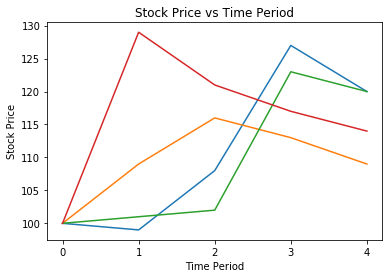

In [74]:
#Below we can see some price changes through the period of time just through random actions,
#But now we can see that there is a decrease in stock price due to the decay factor of this price model

plt.plot(price_change[0])
plt.plot(price_change[1])
plt.plot(price_change[2])
plt.plot(price_change[3])

plt.xticks(np.arange(0, 4+1, 1.0))
plt.title("Stock Price vs Time Period")
plt.ylabel("Stock Price")
plt.xlabel("Time Period")

<font size = '5'> __Part 3) Conclusion__ </font>


Before jumping into conclusion, I first want to note on how would we recover the parameter of the models in real life. Because in real life, we would only observe the the price after we submit the order, and we would not know of the actual parameters of the model. But we can recover them from the Q-Matrix 

__Recovering Theta from Linear Permanent Model__ 

In [739]:
#For this, we can simply look at the Entry of the q matrix at (100.0,0,40.0) with action 40.0 

#Because we know the abs(Reward) = Pt*share, we can set up the equation 5604.261 = 40*(40*theta +noise + 100)

Simulation = []
for i in range(100000):
  theta = (abs(Q.at[(100.0,0,40.0), 40.0])/40 - 100 - R_walk()[0])/40
  Simulation.append(theta)
  
Recovered_theta = sum(Simulation)/len(Simulation)

RelativeError = abs(Recovered - Theta)/Theta
RelativeError

0.002664427633221722

In [740]:
Recovered_theta

1.0026579276332235

We can see that we have succesfully recovered theta = approximately 1  and achiever a low relative error. It is rare to recover the exact theta due to the presence of the noise

__Recovering Theta from Quadratic Model__ 

Because we know the model has the price model 
Pt = Pt−1 + ϵt + a(St)^2 + b(St), we can fit a linear regression model to recover the parameter

Note: the parameter I used earlier was a = 0.5, b =1

In [6]:
#Going to fit a linear regression to recover these parameters


from sklearn.linear_model import LinearRegression

In [0]:
#Setting up the vectors to feed into the linear regression
a_share = []
b_share = []
updatedprice = []
price = [i for i in range(70, 100)]
P_t = []
for i in range(1000):
  share = rm.choice(A)
  p = rm.choice(price)
  P_t.append(p)
  a_share.append(share * share)
  b_share.append(share)
  updatedprice.append(Next_Price_q(p, share))

In [0]:
#I want to dependent varaible to be the price difference, in order for the linear model to just be x1+x2 +noise = y
y = []
for i in range(len(updatedprice)):
  y.append(updatedprice[i] - P_t[i])



In [774]:
#we can see that we achiever a very good model score
D = pd.DataFrame({"st2":a_share, "st":b_share})
x = D.values

model = LinearRegression().fit(x, y)
print("the model score is:",model.score(x, y), "it is very good!")

the model score is: 0.9999885894986238 it is very good!


In [766]:
#ca
Recovered_a = model.coef_[0]
Recovered_b = model.coef_[1]

RelativeError_a = abs(Recovered_a - a)/a
RelativeError_a

0.00044291010501695816

In [767]:
Recovered_a

0.4997785449474915

In [768]:
RelativeError_b = abs(Recovered_b - b)/b
RelativeError_b 

0.008614941121643849

In [769]:
Recovered_b

1.0086149411216438

We can see that we have successfully recover the a, b parameters from the quadartic model using a linear regression and achieve a low relative error. We will stop our demonstration right now as it is hard to recover the parameters from the transient model because at a given state, you dont know how much of the price change was due to the noise vs how much change was due to the exponential sum of actions, as we dont have a record of previous actions


<font size= "5"> __Recap of the three price models and their respective optimal solutions__</font>

To recap, the optimal execution strategy for the models are:

  1) __Linear Permanent Model__: Sell Numberofinitalshare/Time each period, which in our example is selling 40/5 = 8 shares each time for 5 periods. This is exactly the theory we have developed in class, and our empirical study today supports it!
  
  2) __Quadratc Model__: Same strategy, sell 40/5 =8 shares each time for 5 periods. this makese sense because again the price just increases and the effect stays, thus the optimal is just try to split the shares as evenlly as possible.
  
  3) __Transient Model__: When there is only 3 shares to sell in 5 period, the optimal strategy is 1, 0 ,1,0 ,1. which makes sense theoretically because you want the decay to happen for as long as possible belong you have to sell another share, so when there is alot of time periods, you can sell the shares in chunks, skipping some time periods to wait for the decay to happen, before selling more. But of course this will depend on how much the decay is to actually know whether it is worth to not sell any in a time period. So it definitely would depend on the parameter; as we can see in the 6 share case, the optimal strategy is 2,1,1,1,1, and is not the theoreized 2,0,2,0,2
  
  
  And this concludes the project analysis , thank you!